In [ ]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('geolocation.csv', 'geolocation'),
    ('products.csv', 'products'),
    ('order_items.csv', 'order_items'),
    ('payments.csv', 'payments')  # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Abcd@1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'E:/3rd sem subjects and syllabus/Data Analytics/DA minor project/Ecommerce/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

#  We used Python to dumb the data into SQL.  

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db= mysql.connector.connect(host='localhost',
                           username='root',
                           password='Abcd@1234',
                           database='ecommerce')
#to activste cursor in db
cur=db.cursor()


#  List all unique cities where customers are located.  

In [9]:
query=""" select distinct customer_city from customers """

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [12]:
query=""" select count(order_id) from orders where  year(order_purchase_timestamp)= 2017"""

cur.execute(query)

data=cur.fetchall()

"total order placed in 2017 is",data[0][0]

('total order placed in 2017 is', 135303)

# Find the total sale per category.

In [14]:
query=""" select products.product_category category,
round(sum(payments.payment_value),2)sales
from products join order_items
on products.product_id=order_items.product_id
join payments
on payments.order_id=order_items.order_id
group by category"""

cur.execute(query)

data=cur.fetchall()

data
#if u want to visualize your data
#df=pd.DataFrame(data,columns=["Category","Sales"])
#df

[('perfumery', 4560647.94),
 ('Furniture Decoration', 12871587.53),
 ('telephony', 4381938.46),
 ('bed table bath', 15412983.04),
 ('automotive', 7670648.98),
 ('computer accessories', 14267974.02),
 ('housewares', 9852823.17),
 ('babies', 4858610.94),
 ('toys', 5571339.21),
 ('Furniture office', 5821438.38),
 ('Cool Stuff', 7017282.0),
 ('HEALTH BEAUTY', 14916358.07),
 ('pet Shop', 2801420.73),
 ('General Interest Books', 582252.84),
 ('stationary store', 2856960.63),
 ('Watches present', 12862950.11),
 ('PCs', 2512093.94),
 ('climatization', 820535.94),
 ('Construction Tools Construction', 2173280.67),
 ('sport leisure', 12529148.03),
 ('Bags Accessories', 1684361.61),
 ('electronics', 2338713.9),
 ('Casa Construcao', 1229807.61),
 ('Games consoles', 1759323.41),
 ('Fashion Bags and Accessories', 1963424.52),
 ('home appliances', 859790.43),
 ('Garden tools', 7544526.76),
 ('Agro Industria e Comercio', 1068575.49),
 (None, 2275215.39),
 ('audio', 542921.58),
 ('technical books', 2242

# Calculate the percentage of orders that were paid in installments.

In [17]:
query=""" select (sum(case when payment_installments >= 1 then 1 
else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data=cur.fetchall()

"the percentage of orders that were paid in installments is " ,data

('the percentage of orders that were paid in installments is ',
 [(Decimal('99.9981'),)])

# Count the number of customers from each state.

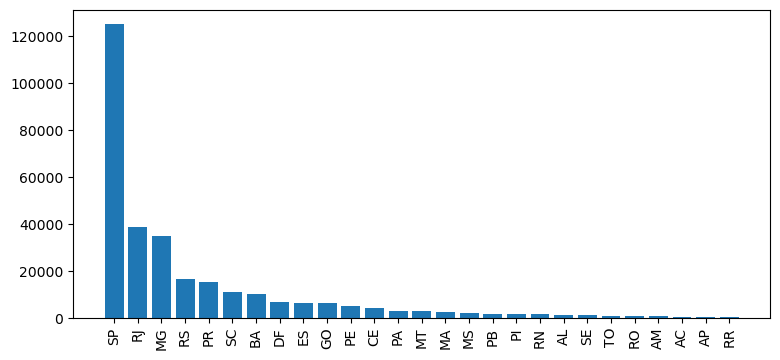

In [19]:
query=""" select customer_state,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data=cur.fetchall()

"the number of customers from each state" ,data
df=pd.DataFrame(data,columns=["state","customer_count"])
df=df.sort_values(by="customer_count", ascending=False)

plt.figure(figsize= (9,4))
plt.bar(df["state"],df["customer_count"])
plt.xticks(rotation=90)
plt.show()

# Calculate the number of orders per month  in 2018.

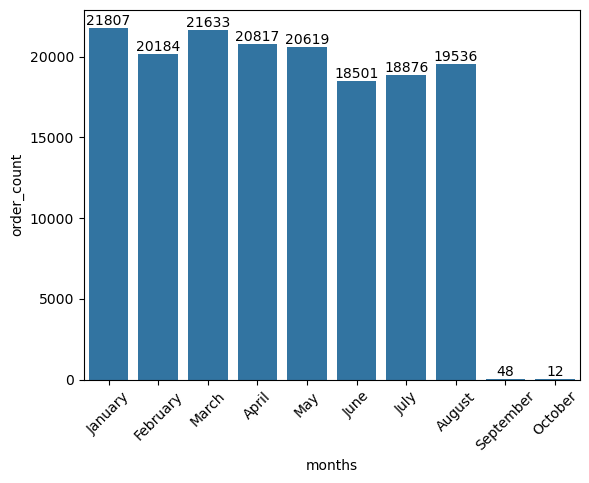

In [21]:
query=""" select monthname(order_purchase_timestamp) months,count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018
group by months
"""

cur.execute(query)

data=cur.fetchall()
data
df = pd.DataFrame(data,columns=["months","order_count"])
o=["January","February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y = df["order_count"],data=df,order=o)
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])

plt.show()

# Find the average number of products per order,grouped by customer city.

In [23]:
query=""" with count_per_order as
(select orders.order_id,orders.customer_id,count(order_items.order_id)as oc
from orders join order_items
on orders.order_id= order_items.order_id
group by orders.order_id,orders.customer_id)

select customers.customer_city,round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id=count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data=cur.fetchall()
df= pd.DataFrame(data,columns=["customer city","average products/orders"])
df.head(10)

,customer city,average products/orders
0,padre carvalho,63.00
1,celso ramos,58.50
2,datas,54.00
3,candido godoi,54.00
4,matias olimpio,45.00
5,cidelandia,36.00
6,curralinho,36.00
7,picarra,36.00
8,morro de sao paulo,36.00
9,teixeira soares,36.00


# Calculate the percentage of total revenue contributed by each product category.

In [25]:
query=""" select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id

join payments 
on payments.order_id= order_items.order_id
group by category order by sales_percentage desc"""

cur.execute(query)

data=cur.fetchall()
df= pd.DataFrame(data,columns=["Category","Percentage distribution"])

df.head()

,Category,Percentage distribution
0,BED TABLE BATH,32.09
1,HEALTH BEAUTY,31.06
2,COMPUTER ACCESSORIES,29.71
3,FURNITURE DECORATION,26.80
4,WATCHES PRESENT,26.78


# Identify teh corelation between product price and the number of times a product has been purchased.

In [27]:
import numpy as np
query=""" select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)

data=cur.fetchall()
df= pd.DataFrame(data,columns=["Category","order_count","price"])

df.head()

arr1= df["order_count"]
arr2= df["price"]

a= np.corrcoef([arr1,arr2])
print(" the corelation between price and number of times a product has been purchased is",a[0][1])

 the corelation between price and number of times a product has been purchased is -0.1063151416715757


# Calculate the  total revenue generated by each seller, and rank them by revenue.

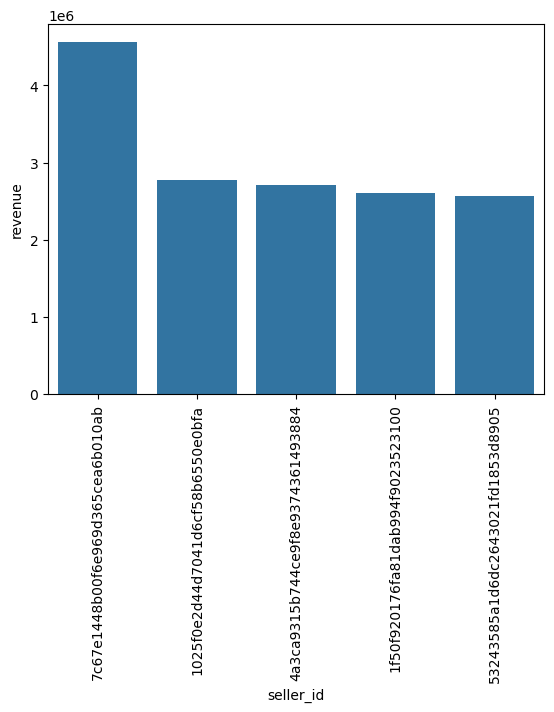

In [29]:
query=""" select*, dense_rank() over(order by revenue desc) as rn from
(select order_items. seller_id,sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by  order_items.seller_id) as a"""

cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data,columns=["seller_id","revenue","rank"])
df=df.head()
sns.barplot(x="seller_id",y="revenue",data=df)
plt.xticks(rotation=90)
plt.show()

# imp question as per interview)Calculate the moving average of order values for each customer over their order history.

In [31]:
query="""select customer_id,order_purchase_timestamp,payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from 
(select orders.customer_id,orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id= orders.order_id) as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
934969,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934970,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934971,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
934972,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cummulative sales per month for each year.

In [33]:
query="""select years, months , sum(payment)
over(order by years, months) cumulative_sales 
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by  years, months)as a"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df

,0,1,2
0,2016,9,2.270160e+03
1,2016,10,5.340845e+05
2,2016,12,5.342611e+05
3,2017,1,1.780653e+06
4,2017,2,4.407826e+06
5,2017,3,8.456598e+06
6,2017,4,1.221669e+07
7,2017,5,1.755296e+07
8,2017,6,2.215445e+07
9,2017,7,2.748589e+07


# Claculate  the year-over growth rate of total sales.

In [61]:
query="""with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment,1) over(order by  years))/ 
lag(payment,1) over (order by years)) * 100 from a"""

cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data,columns = ["years","yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# Calculate the retention rate of customers, define as the percentage of customer who make another purchase within 6 months of their first purchase.

In [66]:
query="""with a as(select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers. customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp <
date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id= b.customer_id"""

cur.execute(query)
data=cur.fetchall()
data

[(None,)]

# Identify  the top 3 customers who spent teh most money in each year.

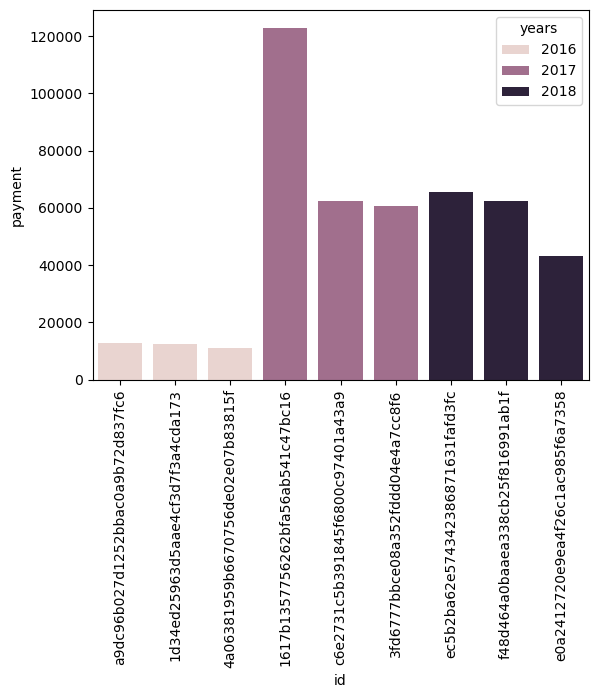

In [86]:
query=""" select years, customer_id, payment ,d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value)desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a

where d_rank <= 3"""

cur.execute(query)
data=cur.fetchall()
df= pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x= "id",y="payment", data = df, hue = "years")
plt.xticks(rotation= 90)
plt.show()